### 1. 引入套件

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### 2. 下載^VIX和^GSPC資料
時間區間為2010-01-01至2024-12-31

In [2]:
start_date = '2010-01-01'
end_date = '2024-12-31'

vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)
gspc = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

### 3. 資料預處理

3.1 建立新的dataframe，收錄^vix每月第一個交易日的Adj Close*0.01，index改為年-月

In [3]:
vix_monthly = vix['Adj Close'].resample('MS').first() * 0.01
vix_monthly.index = vix_monthly.index.to_period('M')

#vix_monthly

Ticker,^VIX
Date,
2010-01,0.2004
2010-02,0.2259
2010-03,0.1926
2010-04,0.1747
2010-05,0.2019
...,...
2024-08,0.1859
2024-09,0.2072
2024-10,0.1926


3.2 建立新的dataframe，收錄^gspc每個月份Adj Close報酬率的年化波動度，index改為年-月

In [4]:
gspc['Monthly_Return'] = gspc['Adj Close'].pct_change()
gspc_volatility = gspc['Monthly_Return'].resample('M').std() * np.sqrt(12)
gspc_volatility = gspc_volatility.to_frame(name='Annualized_Volatility')
gspc_volatility.index = gspc_volatility.index.to_period('M')

#gspc_volatility

<ipython-input-4-9b2543b34e1c>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gspc_volatility = gspc['Monthly_Return'].resample('M').std() * np.sqrt(12)


,Annualized_Volatility
Date,
2010-01,0.033395
2010-02,0.039396
2010-03,0.016347
2010-04,0.032702
2010-05,0.070074
...,...
2024-08,0.042478
2024-09,0.030202
2024-10,0.024028


3.3 合併兩個dataframe

In [5]:
data = pd.concat([vix_monthly, gspc_volatility], axis=1)
data.columns = ['VIX_Adj_Close', 'GSPC_Std_Adj_Close']
data.dropna(inplace=True)

#data

,VIX_Adj_Close,GSPC_Std_Adj_Close
Date,,
2010-01,0.2004,0.033395
2010-02,0.2259,0.039396
2010-03,0.1926,0.016347
2010-04,0.1747,0.032702
2010-05,0.2019,0.070074
...,...,...
2024-08,0.1859,0.042478
2024-09,0.2072,0.030202
2024-10,0.1926,0.024028


### 4. LSTM模型訓練

4.1 模型訓練、測試資料預測與MSE計算函數

In [7]:
def Model_LSTM(train_data, test_data):
  # 進行特徵縮放
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_train = scaler.fit_transform(train_data)
  scaled_test = scaler.transform(test_data)

  # 轉換成LSTM的格式
  X_train = scaled_train[:, 0].reshape(-1, 1, 1)  # VIX_Adj_Close as input
  y_train = scaled_train[:, 1]  # GSPC_Std_Adj_Close as output
  X_test = scaled_test[:, 0].reshape(-1, 1, 1)
  y_test = scaled_test[:, 1]

  # 建立LSTM模型
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(units=1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  # 訓練模型
  model.fit(X_train, y_train, epochs=50, batch_size=36, verbose=1)

  # 預測資料
  predictions = model.predict(X_test)

  # 反向縮放預測與實際資料
  predictions_rescaled = scaler.inverse_transform(np.concatenate((scaled_test[:, 0].reshape(-1, 1), predictions), axis=1))[:, 1]
  y_test_rescaled = scaler.inverse_transform(np.concatenate((scaled_test[:, 0].reshape(-1, 1), y_test.reshape(-1, 1)), axis=1))[:, 1]

  mse = np.mean((y_test_rescaled - predictions_rescaled) ** 2)

  return predictions_rescaled, y_test_rescaled, mse

4.4 預測資料與測試資料作圖函數

In [8]:
def Plot_LSTM(predictions_rescaled, y_test_rescaled, k):
  plt.figure(figsize=(12, 6))
  plt.plot(list(range(1, 13)), y_test_rescaled, label='Actual GSPC Volatility')
  plt.plot(list(range(1, 13)), predictions_rescaled, label='Predicted GSPC Volatility by VIX')
  plt.xlabel('Date')
  plt.ylabel('GSPC Volatility')
  plt.title('VIX Prediction of GSPC Volatility in 2024 with ' + k + 'year(s)')
  plt.legend()
  plt.grid()
  plt.show()

### 5. 結果

5.1 1年訓練、1年測試

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.3092
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3043
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2995
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2947
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2900
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2854
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2808
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2763
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2718
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2673
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2629
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.2586
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.2543
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2500
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2458
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118m

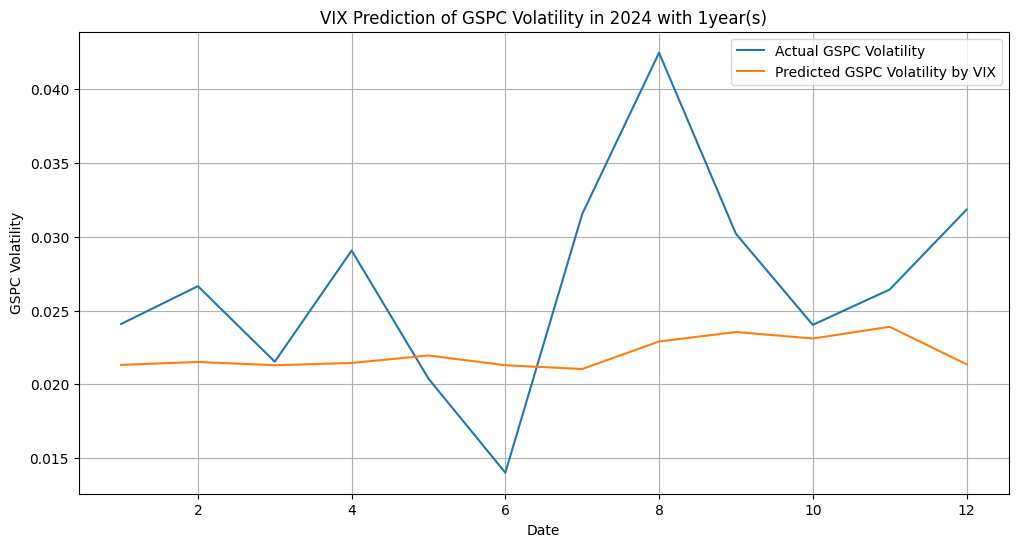

In [9]:
train_data_1 = data.loc['2023-01':'2023-12']
test_data_1 = data.loc['2024-01':'2024-12']

results = Model_LSTM(train_data_1, test_data_1)

print("MSE: "+str(results[2]))
Plot_LSTM(results[0], results[1], '1')

5.2 5年訓練、1年測試

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0371
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0284 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0340 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0315 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0304 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0209 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0259 
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0237 
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225 
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0215 
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131 
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0200 
Epoch 16/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

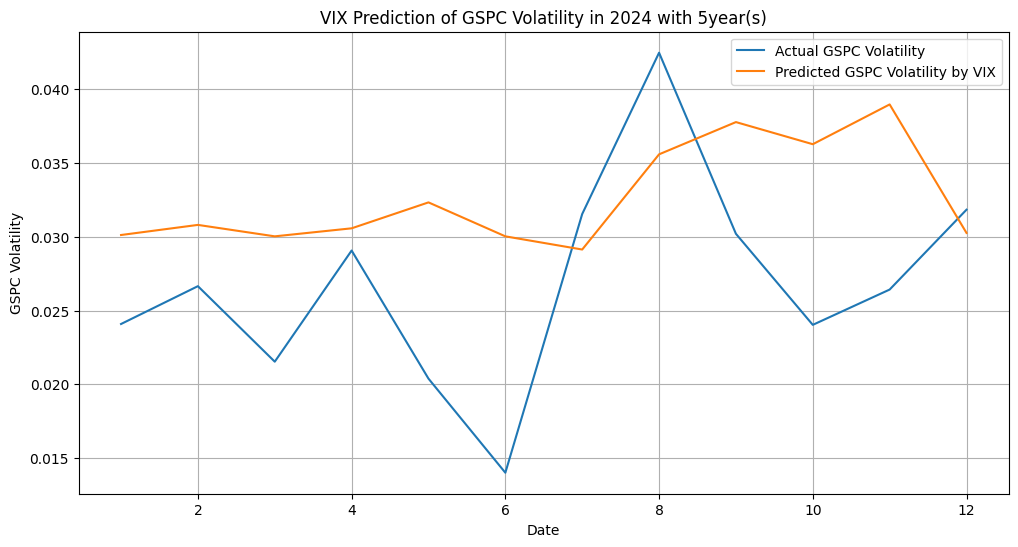

In [10]:
train_data_5 = data.loc['2019-01':'2023-12']
test_data_1 = data.loc['2024-01':'2024-12']

results = Model_LSTM(train_data_5, test_data_1)

print("MSE: "+str(results[2]))
Plot_LSTM(results[0], results[1], '5')

5.3 10年訓練、1年測試

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0248
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0129 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

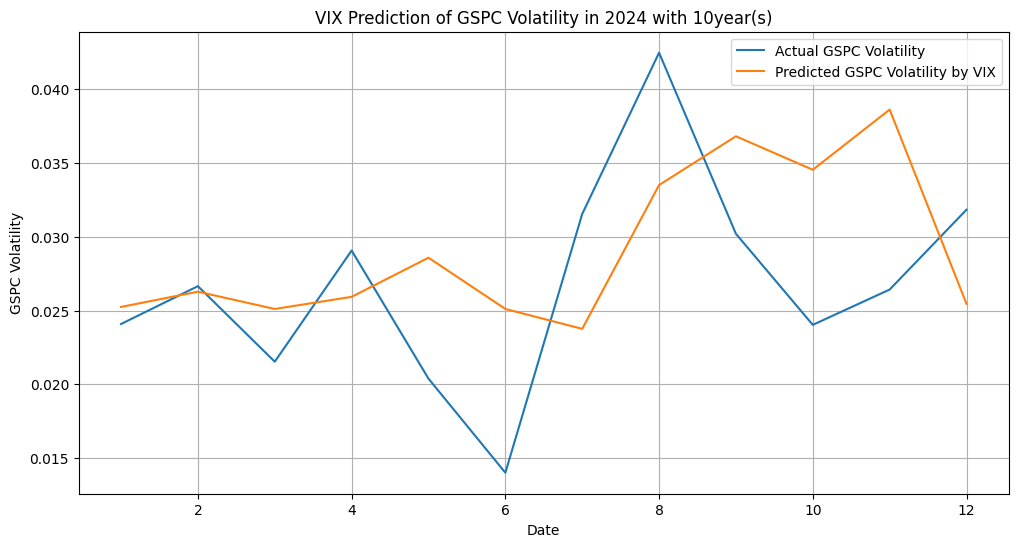

In [11]:
train_data_10 = data.loc['2014-01':'2023-12']
test_data_1 = data.loc['2024-01':'2024-12']

results = Model_LSTM(train_data_10, test_data_1)

print("MSE: "+str(results[2]))
Plot_LSTM(results[0], results[1], '10')